In [3]:
%matplotlib notebook
import numpy as np
from modsim import *
import math

# 125 meters in between each building


In [30]:
def make_frisbee_system(x, y, vx, vy, alpha, duration):
    """
    """
    init = State(x=x, y=y, vx=vx, vy=vy)
    g = 9.8 #* UNITS.meter / UNITS.second**2
    m = .175 #* UNITS.kilogram # Mass of frisbee
    rho = 1.23  #* UNITS.kilogram/UNITS.meter**3 # Density of air
    area = 0.0568 #* UNITS.meter**2 # Surface area of frisbee
    CL0 = 0.1 # Lift coefficient alpha=0.
    CLA = 1.4 # Alpha-dependent lift coefficient
    # Drag coefficient when alpha = 0
    CD0 = 0.08
    # Alpha-dependent drag coefficient
    CDA = 2.72 
    # Constant associated with launch angle.
    alpha_constant = -4
    # Launch angle (in degrees).
    alpha = alpha

    # Now that we have lots of constants, we can calculate the actual coefficients.
    # Lift coefficient.
    CL = CL0 + CLA*alpha_constant*math.pi/180
    # print(CL)
    # Drag coefficient.
    CD = CD0 + CDA*((alpha - alpha_constant) * math.pi/180)**2
    # print(CD)
    # Array of times around which this should be created.
    ts = linspace(0, duration)
    # Return our system, because real object oriented programming is "soooo overrated"
    return System(init=init, g=g, m=m, rho=rho, area=area, CL=CL, CD=CD, ts=ts)

def frisbee_slope_func(state, t, system):
    """
    """
    x, y, vx, vy = state
    unpack(system)

    # Make some useful vectors.
    a_grav = Vector(0, -g)
    # v = Vector(vx, vy)
    
    # Make some change vectors.
    ax = (rho*(vx**2)*area*CD)/2*m
    ay = (((rho*(vy**2)*area*(CL))/2) - 9.8)/m
    
    return vx, vy, ax, ay



<IPython.core.display.Javascript object>


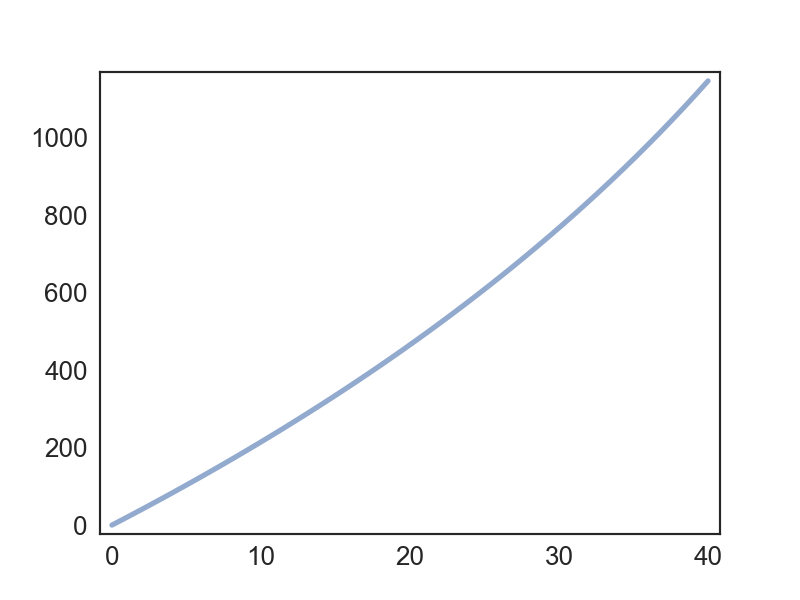

In [31]:
sys = make_frisbee_system(0, 0, 20, 20, 2, 40)
run_odeint(sys, frisbee_slope_func)
plot(sys.results.x)